In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from pca_utils import (rfiw_phantom, mp_distribution,
                       fiber_segments_phantom, pca_denoising,
                       evaluate_directions, evaluate_metric)

In [3]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

acquisition = 1

if acquisition == 0:

    # Sample 8 diffusion-weighted directions for first shell
    n_pts = 8
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    directions8 = hsph_updated.vertices  # directions for each shell

    # Sample 30 diffusion-weighted directions for second shell
    n_pts = 30
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 50000)
    directions30 = hsph_updated.vertices  # directions for each shell

    # Sample 60 diffusion-weighted directions for second shell
    n_pts = 60
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 50000)
    directions60 = hsph_updated.vertices  # directions for each shell

    # Create full dataset parameters
    bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                       1000 * np.ones(30), 2000 * np.ones(60)))
    bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
    gtab = gradient_table(bvals, bvecs)
    
else:
    # Sample 30 diffusion-weighted directions for second shell
    n_pts = 30
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 50000)
    directions30 = hsph_updated.vertices  # directions for each shell

    # Create full dataset parameters
    bvals = np.hstack((np.zeros(6), 1000 * np.ones(30), 2000 * np.ones(30)))
    bvecs = np.vstack((np.zeros((6, 3)), directions30, directions30))
    gtab = gradient_table(bvals, bvecs)

In [11]:
p = 0
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
snr1 = np.zeros(fsigmas.size)
snr2 = np.zeros(snr1.shape)
snr3 = np.zeros(snr1.shape)

snr = 15
sigma = 50.0 /snr

Phantom = fiber_segments_phantom(gtab, fsigmas[p])

matsiz = Phantom.shape
nrep=20
matsiz = matsiz + (nrep,)
Phantom_all = np.zeros(matsiz)
Pden_all = np.zeros(matsiz)


n1 = np.random.normal(0, sigma, size=Phantom.shape)
n2 = np.random.normal(0, sigma, size=Phantom.shape)
Phantom_gt = _add_rician(Phantom.copy(), n1, n2)
Phantom_all[..., 0] = Phantom_gt
[Pden, sig, ncomps] = pca_denoising(Phantom_all[..., 0].copy(), psize=2)
Pden_all[..., 0] = Pden

for rep in range(1, nrep):
    # add noise
    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_all[..., rep] = _add_rician(Phantom.copy(), n1, n2)
    Phantom_gt = Phantom_gt + Phantom_all[..., rep]
    [Pden, sig, ncomps] = pca_denoising(Phantom_all[..., rep].copy(), psize=2)
    Pden_all[..., rep] = Pden
Phantom_gt = Phantom_gt / nrep

In [12]:
Pen_std = np.mean(np.mean(np.mean(np.std(Pden_all[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
print Pen_std.shape

(66L,)


In [13]:
Raw_std = np.mean(np.mean(np.mean(np.std(Phantom_all[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
print Raw_std.shape

(66L,)


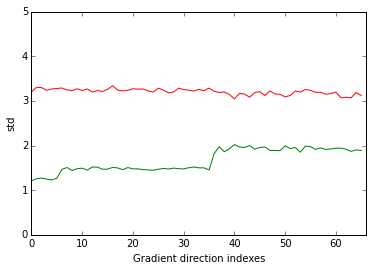

In [14]:
plt.plot(range(Raw_std.size), Raw_std, 'r')
plt.plot(range(Raw_std.size), Pen_std, 'g')
plt.axis([0, Raw_std.size, 0, 5])
plt.xlabel('Gradient direction indexes')
plt.ylabel('std')
plt.show()

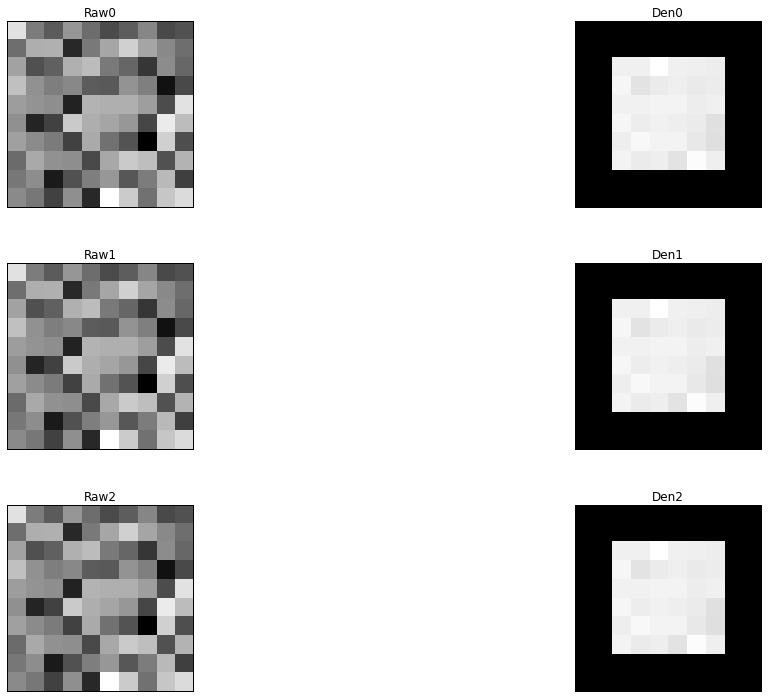

In [15]:
fig2, ax = plt.subplots(3, 2, figsize=(18, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.3)

vol = 0

ax.flat[0].imshow(Phantom_all[:, :, 3, vol, 0], cmap='gray', interpolation="nearest")
ax.flat[0].set_title('Raw0')
ax.flat[1].imshow(Pden_all[:, :, 3, vol, 0], cmap='gray', interpolation="nearest")
ax.flat[1].set_title('Den0')
ax.flat[2].imshow(Phantom_all[:, :, 3, vol, 0], cmap='gray', interpolation="nearest")
ax.flat[2].set_title('Raw1')
ax.flat[3].imshow(Pden_all[:, :, 3, vol, 0], cmap='gray', interpolation="nearest")
ax.flat[3].set_title('Den1')
ax.flat[4].imshow(Phantom_all[:, :, 3, vol, 0], cmap='gray', interpolation="nearest")
ax.flat[4].set_title('Raw2')
ax.flat[5].imshow(np.squeeze(Pden_all[:, :, 3, vol, 0]), cmap='gray', interpolation="nearest")
ax.flat[5].set_title('Den2')
plt.show()

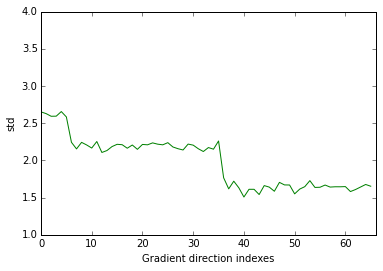

In [17]:
Ganho = Raw_std/Pen_std
plt.plot(range(Raw_std.size), Ganho, 'g')
plt.axis([0, Raw_std.size, 1, 4])
plt.xlabel('Gradient direction indexes')
plt.ylabel('std')
plt.show()

In [57]:
Ganho

array([ 2.27554538,  2.27353105,  2.37822681,  2.29186309,  2.33384055,
        2.27816407,  2.26183705,  2.24361399,  2.2402293 ,  2.19528708,
        2.31147977,  2.26590406,  2.33259207,  2.19791934,  2.09997225,
        2.12741429,  2.08484764,  2.11235855,  2.11572574,  2.09064393,
        2.12373411,  2.08381753,  2.09776813,  2.11831663,  2.03396178,
        2.13294489,  2.05647115,  2.08742963,  2.1170699 ,  2.09776514,
        2.07392649,  2.0703728 ,  2.13931726,  2.07406277,  2.1150145 ,
        2.08106186,  2.11069693,  2.13605777,  2.11115517,  2.15812178,
        2.07433077,  2.06394833,  2.10145075,  2.09052284,  1.73344445,
        1.69884417,  1.70901454,  1.6808139 ,  1.66828215,  1.69342004,
        1.69775029,  1.66448696,  1.72710478,  1.65370679,  1.68538217,
        1.70142136,  1.66564292,  1.69456468,  1.66967272,  1.65410965,
        1.69076965,  1.69580948,  1.6657056 ,  1.67246537,  1.64704197,
        1.72870773,  1.6786509 ,  1.68961868,  1.74203041,  1.69

In [18]:
Ganho

array([ 2.65184897,  2.62905797,  2.59322978,  2.59459264,  2.65644982,
        2.58413862,  2.24301394,  2.15451508,  2.24251767,  2.20739307,
        2.16605401,  2.25380718,  2.10664507,  2.13250608,  2.18586399,
        2.21619473,  2.210971  ,  2.1636398 ,  2.20689262,  2.14877448,
        2.21458035,  2.2094487 ,  2.23546531,  2.21815837,  2.20932684,
        2.2383577 ,  2.18050089,  2.15721989,  2.13994183,  2.21912639,
        2.20512269,  2.15697173,  2.11939484,  2.17264096,  2.15084836,
        2.2611283 ,  1.76655267,  1.61776154,  1.72066056,  1.63131336,
        1.50789475,  1.61149683,  1.61157164,  1.54114756,  1.66126027,
        1.6409083 ,  1.58517032,  1.70473185,  1.67038007,  1.66940587,
        1.55021781,  1.6143086 ,  1.64708155,  1.72797439,  1.63666176,
        1.63907852,  1.66886539,  1.64143032,  1.64551787,  1.64536267,
        1.64788666,  1.58113384,  1.60845972,  1.64238354,  1.67640147,
        1.65281335])

In [20]:
ganho30 = np.array([ 2.65184897,  2.62905797,  2.59322978,  2.59459264,  2.65644982,
        2.58413862,  2.24301394,  2.15451508,  2.24251767,  2.20739307,
        2.16605401,  2.25380718,  2.10664507,  2.13250608,  2.18586399,
        2.21619473,  2.210971  ,  2.1636398 ,  2.20689262,  2.14877448,
        2.21458035,  2.2094487 ,  2.23546531,  2.21815837,  2.20932684,
        2.2383577 ,  2.18050089,  2.15721989,  2.13994183,  2.21912639,
        2.20512269,  2.15697173,  2.11939484,  2.17264096,  2.15084836,
        2.2611283 ,  1.76655267,  1.61776154,  1.72066056,  1.63131336,
        1.50789475,  1.61149683,  1.61157164,  1.54114756,  1.66126027,
        1.6409083 ,  1.58517032,  1.70473185,  1.67038007,  1.66940587,
        1.55021781,  1.6143086 ,  1.64708155,  1.72797439,  1.63666176,
        1.63907852,  1.66886539,  1.64143032,  1.64551787,  1.64536267,
        1.64788666,  1.58113384,  1.60845972,  1.64238354,  1.67640147,
        1.65281335])

In [22]:
ganho60 = np.array([ 2.27554538,  2.27353105,  2.37822681,  2.29186309,  2.33384055,
        2.27816407,  2.26183705,  2.24361399,  2.2402293 ,  2.19528708,
        2.31147977,  2.26590406,  2.33259207,  2.19791934,  2.09997225,
        2.12741429,  2.08484764,  2.11235855,  2.11572574,  2.09064393,
        2.12373411,  2.08381753,  2.09776813,  2.11831663,  2.03396178,
        2.13294489,  2.05647115,  2.08742963,  2.1170699 ,  2.09776514,
        2.07392649,  2.0703728 ,  2.13931726,  2.07406277,  2.1150145 ,
        2.08106186,  2.11069693,  2.13605777,  2.11115517,  2.15812178,
        2.07433077,  2.06394833,  2.10145075,  2.09052284,  1.73344445,
        1.69884417,  1.70901454,  1.6808139 ,  1.66828215,  1.69342004,
        1.69775029,  1.66448696,  1.72710478,  1.65370679,  1.68538217,
        1.70142136,  1.66564292,  1.69456468,  1.66967272,  1.65410965,
        1.69076965,  1.69580948,  1.6657056 ,  1.67246537,  1.64704197,
        1.72870773,  1.6786509 ,  1.68961868,  1.74203041,  1.69660909,
        1.6612484 ,  1.70749758,  1.67689583,  1.66786569,  1.71528325,
        1.69011653,  1.65665078,  1.72380688,  1.66572288,  1.69154507,
        1.708063  ,  1.67547481,  1.63746616,  1.67512029,  1.66126113,
        1.6957201 ,  1.67797587,  1.68758876,  1.7207059 ,  1.67703596,
        1.69360855,  1.70128164,  1.71149846,  1.6819139 ,  1.67511356,
        1.67089447,  1.68593343,  1.67176923,  1.66065981,  1.64951255,
        1.72352282,  1.6855358 ,  1.67468888,  1.70043337])

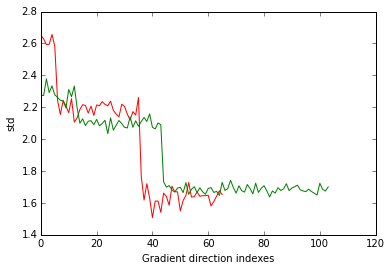

In [24]:
plt.plot(ganho30, 'r')
plt.plot(ganho60, 'g')
plt.xlabel('Gradient direction indexes')
plt.ylabel('std')
plt.show()